## A varianz ML model

problem: the former model struggles with around 20-30% false negatives. Analyzing some example data hintted to the idea, that the problem could be with the training data as is does not take into account that the AF predictions itself may be wrong.

idea: from AF per prediction 5 files are available. Maybe its better to merge them into one row.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pathlib import Path
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import sklearn
import pickle
import re

In [2]:
# First creating the human readable dataset
measureAF = pd.read_csv(Path("../ressources//af_structures.csv"))
measureSolved = pd.read_csv(Path("../ressources//solved_structures.csv"))
predictionAF = pd.read_excel(Path("../ressources/ISS AF_DMI_structures/AF_prediction_randomized_DMI_results.xlsx"))

measureAF["file"] = measureAF["file"].str.replace(".pdb", "")
measureSolved["file"] = measureSolved["file"].str.replace(".pdb", "")

measureSolved.index = measureSolved.apply(lambda row: row["structure_name"].split("_")[0], axis=1)
measureAF.index = measureAF["structure_name"] + "_" + measureAF["file"]
predictionAF.index = predictionAF["prediction_name"] + "_" + predictionAF["model_id"]


dataAF = pd.merge(
    left=predictionAF,
    right=measureAF, 
    how='inner',
    left_index=True,
    right_index=True
    #left_on=['prediction_name', 'model_id'],
    #right_on=['structure_name', 'file'],
)
if len(measureAF) > len(dataAF):
    print(f"{len(measureAF) - len(dataAF)} structures not found in the predictionAF excel sheet")


dataAF.drop(columns=["structure_name", "file"], inplace=True)
dataAF["solved structure"] = dataAF.apply(lambda row: None if not (r := re.search(r"^([\w_]+)_([\w]{4})$", row["prediction_name"])) or len(r.groups()) != 2 else r.groups()[1], axis=1)

dataAF["min_distance"] = dataAF["min_distance"].fillna(value=20)

aggregation_functions = {
    "chainA_length" : "first",
    "chainB_length" : "first",
    "label": "first"
}
for c in ["model_confidence","chainA_intf_avg_plddt", "chainB_intf_avg_plddt", "intf_avg_plddt", "pDockQ", "iPAE", "num_chainA_intf_res", "num_chainB_intf_res", "num_res_res_contact", "num_atom_atom_contact", "hbonds", "salt_bridges", "buried_area", "min_distance", "hydrophobic_interactions"]:
    dataAF[f"{c}_var"] = dataAF[c]
    aggregation_functions[c] = "mean"
    aggregation_functions[f"{c}_var"] = "var"

dataAF = dataAF.groupby(dataAF["prediction_name"]).aggregate(aggregation_functions)

display(dataAF)




10 structures not found in the predictionAF excel sheet


,chainA_length,chainB_length,label,model_confidence,model_confidence_var,chainA_intf_avg_plddt,chainA_intf_avg_plddt_var,chainB_intf_avg_plddt,chainB_intf_avg_plddt_var,intf_avg_plddt,...,hbonds,hbonds_var,salt_bridges,salt_bridges_var,buried_area,buried_area_var,min_distance,min_distance_var,hydrophobic_interactions,hydrophobic_interactions_var
prediction_name,,,,,,,,,,,,,,,,,,,,,
DEG_APCC_KENBOX_2_4GGD,312,5,1,0.658525,0.064476,95.385203,0.392362,50.130267,780.079776,83.289170,...,6.4,16.3,0.0,0.0,515.5734,21488.857800,5.7454,0.214072,2.4,15.3
DEG_COP1_1_5IGO,324,8,1,0.684335,0.001196,91.986913,0.212147,48.149072,59.723086,79.940514,...,5.6,0.3,0.4,0.8,987.6414,4821.742499,4.9706,0.182999,55.4,2.3
DEG_Kelch_Keap1_1_2FLU,285,6,1,0.912952,0.003388,98.573256,0.099657,84.792333,132.624814,95.273913,...,11.4,1.8,10.4,1.8,865.4100,1469.364296,5.5978,0.026572,4.6,6.8
DEG_Kelch_Keap1_2_3WN7,286,7,1,0.729614,0.000350,96.043932,0.136739,49.575858,15.775117,84.769967,...,6.0,4.5,3.8,3.7,922.6578,4525.291303,5.2998,0.123649,20.8,47.7
DEG_MDM2_SWIB_1_1YCR,80,8,1,0.800980,0.015392,96.558750,4.963150,84.766667,221.107522,93.342728,...,1.4,0.8,0.0,0.0,962.3820,824.202765,5.2176,0.545669,101.6,150.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRG_ER_FFAT_1_2RR3,125,9,1,0.855129,0.000094,95.850941,0.350045,89.080000,8.376464,93.626274,...,7.2,0.2,0.2,0.2,1139.6262,310.749350,4.3240,0.000270,55.0,4.5
TRG_LysEnd_GGAAcLL_1_1JWG,147,7,1,0.683908,0.006876,94.105574,2.219293,53.540914,176.010600,81.799558,...,3.6,4.3,0.8,0.7,902.0672,9692.181424,5.9558,0.067274,50.4,80.3
TRG_NES_CRM1_1_3GB8,179,16,1,0.720393,0.016362,93.257389,9.592621,67.433538,259.331741,83.128770,...,4.0,1.5,3.0,3.5,1272.6568,47055.019215,4.7488,0.017580,88.8,342.7


In [3]:
X = dataAF.drop(columns=["label"])
Y = dataAF[["label"]]
print("NaN values in dataset X")
display(X[X.isnull().any(axis=1)])
#X.index = dataAF["structure_name"] + "_" + dataAF["file"]
#Y.index = dataAF["structure_name"] + "_" + dataAF["file"]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2501)
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

display(X)
display(Y)

NaN values in dataset X


,chainA_length,chainB_length,model_confidence,model_confidence_var,chainA_intf_avg_plddt,chainA_intf_avg_plddt_var,chainB_intf_avg_plddt,chainB_intf_avg_plddt_var,intf_avg_plddt,intf_avg_plddt_var,...,hbonds,hbonds_var,salt_bridges,salt_bridges_var,buried_area,buried_area_var,min_distance,min_distance_var,hydrophobic_interactions,hydrophobic_interactions_var
prediction_name,,,,,,,,,,,,,,,,,,,,,
LIG_LYPXL_SIV_4_2XS1,697,9,0.856474,NaN,89.844286,NaN,68.352857,NaN,84.471428,NaN,...,2.0,NaN,2.0,NaN,1179.250,NaN,4.535,NaN,63.0,NaN
MLIG_LYPXL_L_2_2R02.DLIG_PTAP_UEV_1_1M4P,144,10,0.333206,NaN,95.181429,NaN,26.856667,NaN,74.684000,NaN,...,0.0,NaN,0.0,NaN,846.435,NaN,5.806,NaN,51.0,NaN


Training set shape: (216, 32)
Test set shape: (54, 32)


,chainA_length,chainB_length,model_confidence,model_confidence_var,chainA_intf_avg_plddt,chainA_intf_avg_plddt_var,chainB_intf_avg_plddt,chainB_intf_avg_plddt_var,intf_avg_plddt,intf_avg_plddt_var,...,hbonds,hbonds_var,salt_bridges,salt_bridges_var,buried_area,buried_area_var,min_distance,min_distance_var,hydrophobic_interactions,hydrophobic_interactions_var
prediction_name,,,,,,,,,,,,,,,,,,,,,
DEG_APCC_KENBOX_2_4GGD,312,5,0.658525,0.064476,95.385203,0.392362,50.130267,780.079776,83.289170,71.923672,...,6.4,16.3,0.0,0.0,515.5734,21488.857800,5.7454,0.214072,2.4,15.3
DEG_COP1_1_5IGO,324,8,0.684335,0.001196,91.986913,0.212147,48.149072,59.723086,79.940514,15.144374,...,5.6,0.3,0.4,0.8,987.6414,4821.742499,4.9706,0.182999,55.4,2.3
DEG_Kelch_Keap1_1_2FLU,285,6,0.912952,0.003388,98.573256,0.099657,84.792333,132.624814,95.273913,9.066702,...,11.4,1.8,10.4,1.8,865.4100,1469.364296,5.5978,0.026572,4.6,6.8
DEG_Kelch_Keap1_2_3WN7,286,7,0.729614,0.000350,96.043932,0.136739,49.575858,15.775117,84.769967,0.499509,...,6.0,4.5,3.8,3.7,922.6578,4525.291303,5.2998,0.123649,20.8,47.7
DEG_MDM2_SWIB_1_1YCR,80,8,0.800980,0.015392,96.558750,4.963150,84.766667,221.107522,93.342728,32.007436,...,1.4,0.8,0.0,0.0,962.3820,824.202765,5.2176,0.545669,101.6,150.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRG_ER_FFAT_1_2RR3,125,9,0.855129,0.000094,95.850941,0.350045,89.080000,8.376464,93.626274,1.891435,...,7.2,0.2,0.2,0.2,1139.6262,310.749350,4.3240,0.000270,55.0,4.5
TRG_LysEnd_GGAAcLL_1_1JWG,147,7,0.683908,0.006876,94.105574,2.219293,53.540914,176.010600,81.799558,29.248166,...,3.6,4.3,0.8,0.7,902.0672,9692.181424,5.9558,0.067274,50.4,80.3
TRG_NES_CRM1_1_3GB8,179,16,0.720393,0.016362,93.257389,9.592621,67.433538,259.331741,83.128770,62.774387,...,4.0,1.5,3.0,3.5,1272.6568,47055.019215,4.7488,0.017580,88.8,342.7


,label
prediction_name,
DEG_APCC_KENBOX_2_4GGD,1
DEG_COP1_1_5IGO,1
DEG_Kelch_Keap1_1_2FLU,1
DEG_Kelch_Keap1_2_3WN7,1
DEG_MDM2_SWIB_1_1YCR,1
...,...
TRG_ER_FFAT_1_2RR3,1
TRG_LysEnd_GGAAcLL_1_1JWG,1
TRG_NES_CRM1_1_3GB8,1


In [4]:
x_test

,chainA_length,chainB_length,model_confidence,model_confidence_var,chainA_intf_avg_plddt,chainA_intf_avg_plddt_var,chainB_intf_avg_plddt,chainB_intf_avg_plddt_var,intf_avg_plddt,intf_avg_plddt_var,...,hbonds,hbonds_var,salt_bridges,salt_bridges_var,buried_area,buried_area_var,min_distance,min_distance_var,hydrophobic_interactions,hydrophobic_interactions_var
prediction_name,,,,,,,,,,,,,,,,,,,,,
MLIG_AP2alpha_1_1KY7.DLIG_PAM2_1_1JGN,73,5,0.257125,0.009497,38.748333,2815.261320,13.984666,415.815999,31.354000,1856.773803,...,0.00,0.00,0.0,0.0,120.56240,34777.045111,12.45760,48.891781,9.0,272.000000
LIG_PDZ_Class_3_1B8Q,86,6,0.482050,0.004433,90.341064,11.731106,52.471067,97.542572,79.641203,25.066538,...,1.40,2.80,0.0,0.0,686.27740,5359.571483,4.88500,0.623960,39.6,42.300000
LIG_EH1_1_2CE8,337,9,0.900101,0.000033,97.207967,0.053707,81.713890,5.671698,91.957179,0.876279,...,4.00,1.50,0.6,0.8,1049.24700,278.928368,6.97080,0.053463,68.4,10.800000
MLIG_DLG_GKlike_1_3WP0.DTRG_ER_FFAT_1_2RR3,125,9,0.526334,0.021408,93.617427,0.985208,49.791022,259.404789,77.598651,26.791248,...,2.80,1.70,0.4,0.3,853.82560,16781.209763,4.28180,0.082265,28.0,16.500000
MLIG_TPR_1ELR.DDOC_ANK_TNKS_1_3TWU,160,4,0.724851,0.003454,97.797455,0.057139,60.280000,46.161052,87.792800,3.892154,...,4.40,0.30,3.8,3.7,640.02580,728.915894,5.62320,0.006179,9.2,3.700000
MDOC_MAPK_RevD_3_3TEI.DLIG_EF_ALG2_ABM_1_2ZNE,168,15,0.341084,0.000890,90.453271,2.115182,26.637175,1.465870,69.768982,7.724450,...,3.80,2.70,0.6,0.8,1254.11760,32322.863287,4.38980,0.030539,70.8,970.700000
TRG_DiLeu_BaEn_1_4NEE,142,6,0.817848,0.000358,96.888000,0.169204,85.326000,6.503369,93.845369,0.913216,...,1.80,0.20,0.0,0.0,780.33360,53.992137,4.81420,0.009488,37.8,1.700000
MLIG_PCNA_APIM_2_5MLW.DDEG_SPOP_SBC_1_3HQM,137,7,0.570616,0.001320,95.126319,0.621765,51.744381,52.258950,83.622925,8.065619,...,5.00,3.50,0.2,0.2,1005.88480,3675.437567,5.04200,0.013634,53.4,151.300000
LIG_CaM_IQ_9_2IX7,139,17,0.381686,0.001542,70.854568,2.922352,45.974462,3.074339,63.696511,5.194431,...,7.40,0.30,12.8,2.2,2134.85420,14805.741447,5.81260,0.069752,106.2,388.200000


## Model training

In [5]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, auc


def VisualizeModel(model: RandomForestClassifier, x_test, y_test):
    y_pred = model.predict(x_test)
    y_preda = model.predict_proba(x_test)

    score = accuracy_score(y_test, y_pred)
    rocauc_score = roc_auc_score(y_test, y_preda[:, 1])
    print(f"Score: {round(score, 3)}")
    print(f"ROC AUC score: {round(rocauc_score, 3)}")

    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    cm = confusion_matrix(y_test, y_pred)
    imshow_cm = plt.imshow(cm, cmap="Blues")
    plt.colorbar(imshow_cm)
    plt.xticks(range(cm.shape[0]), labels=["Negative", "Positive"])
    plt.yticks(range(cm.shape[1]), labels=["Negative", "Positive"])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            c = "black" if colors.rgb_to_hsv(imshow_cm.cmap(cm[i,j])[:3])[1] < 0.4 else "white"
            text = plt.text(j, i, cm[i, j], ha="center", va="center", color=c)
    plt.show()


    roc_conf_X, roc_conf_Y, _ = roc_curve(y_test, x_test["model_confidence"])
    roc_conf = auc(roc_conf_X, roc_conf_Y)
    roc_model_X, roc_model_Y, _ = roc_curve(y_test, y_preda[:, 1])
    roc_model = auc(roc_model_X, roc_model_Y)

    plt.plot(roc_conf_X, roc_conf_Y, label=f"model confidence (AUC = {roc_conf:.2f})")
    plt.plot(roc_model_X, roc_model_Y, label=f"ml prediction (AUC = {roc_model:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC Curve for Model and Test Subset Features")
    plt.legend(loc="lower right")
    plt.show()

    df = x_test.copy()
    df["label"] = y_test["label"]
    df["prediction"] = y_pred
    df["negative"] = y_preda[:, 0]
    df["positive"] = y_preda[:, 1]

    #df = df[df["label"] != df["prediction"]]
    
    df.sort_values(by=["label", "prediction", "negative"], inplace=True)
    return df

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Score: 0.778
ROC AUC score: 0.768


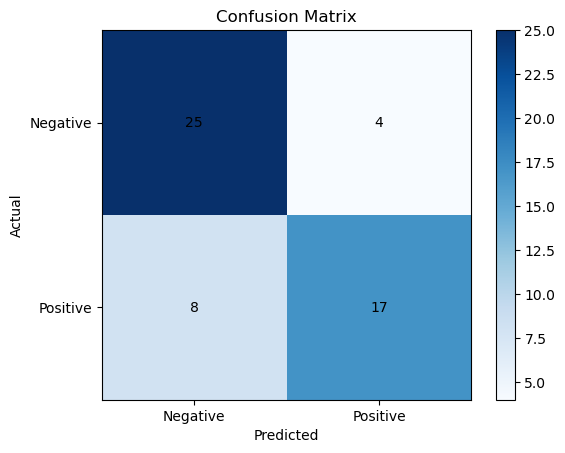

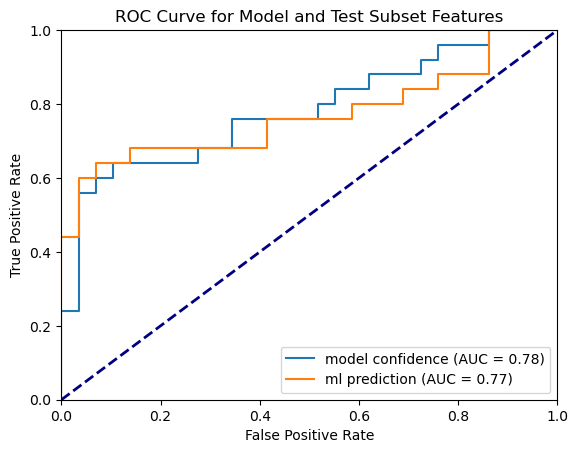

RandomForestClassifier(criterion='entropy', max_depth=12, max_features=15,
                       min_samples_leaf=5, n_estimators=200, random_state=2501)

In [6]:
rf_param_grid_vB1 = {
    "criterion": ["gini", "entropy", "log_loss"],
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [4, 6, 8, 12,None],
    "min_samples_leaf": [1,2,3,4,5,10],
    "max_features" : [6,8,10, 15, 20, 25, 30]
}

rf_vB1 = RandomForestClassifier(random_state=2501)
random_search_vB1 = RandomizedSearchCV(n_iter=30, estimator=rf_vB1, param_distributions=rf_param_grid_vB1, scoring='accuracy', n_jobs=-1, verbose=2, random_state=2501)
random_search_vB1.fit(x_train, y_train["label"])
rf_best_vB1 = random_search_vB1.best_estimator_
wrong_predictions_vA1 = VisualizeModel(rf_best_vB1, x_test, y_test)
rf_best_vB1